## Model Output for Users

In the previous lesson, we looked at different ways to evaluate binary classification models. Now, we have the tools to compare different models that we run and can evaluate tradeoffs between them. However, often the concern for implementation of these models is how to display results to an end-user of some sort. 

## Calibration

One of the most common concerns for model outputs is whether they are *calibrated* or not. To understand what calibration is, it is useful to think of weather forecasting.

When the weather forecaster says, "There is an 80% chance of rain tomorrow," how is it possible to evaluate whether or not there is an 80% chance of rain? Since it only either rains or does not rain, only looking at once outcome does not determine whether or not the weather forecaster is correct or not. The weather forecaster could have estimated a 70% or 90% chance of rain instead. 

This is the general problem of calibration. A *well-calibrated* probability prediction is one where the long-term proportion of positive cases is close to the predicted probability. In the weather forecasting example, of all the times that the weather forecaster predicts 80% chance of rain, if the true proportion is close to 80%, then the weather forecaster is said to be *well-calibrated*. 

It turns out that many machine learning models, although they optimize for being able to discriminate between positive and negative examples, do *not* optimize for model calibration.

if model output is being displayed to users, it is recommended that the model be calibrated in order to not mislead the end users.

## Assessing Calibration

The easiest way to assess whether or not a model is well-calibrated is to use a calibration plot (also known as a reliability plot). A calibration plot is simply a plot that has the predicted probabilities on the y-axis and the actual observed proportions of events on the x-axis. Because there may not be enough data points to have a stable proportion, often the data is binned into deciles (0-10%, 10-20%, etc.). The predicted probabilities on the y-axis are then usually represented as the middle of the decile (5%, 15%, etc.). 

A perfectly calibrated classifier would fall exactly on the y=x line (meaning that the predicted probabilities are exactly the observed probabilities). However, in practice this is rarely the case, and it sensitive to the model type as well as the overall prevalence of the outcome.

In [1]:
import pandas as pd 
example_output1 = pd.read_csv("./assets/example_output.csv")

In [2]:
example_output1['prediction'] = pd.to_numeric(example_output1['prediction'], errors = 'coerce')

In [3]:
# X-axis:
# For each decile, find the proportion of outcomes that are positive (1)

In [4]:
example_x = []
for cutoff in range(0, 10):
    (example_x.append(
        example_output1.loc[(example_output1['prediction'] >= cutoff * 0.1) & 
                            (example_output1['prediction'] < (cutoff * 0.1 + 0.1)), 
                            ['outcome']].mean().values[0]))

In [5]:
example_x

[0.014068697148843822,
 0.2198581560283688,
 0.19117647058823528,
 0.2692307692307692,
 0.3181818181818182,
 0.6363636363636364,
 0.625,
 0.4,
 0.6,
 0.8]

In [6]:
# Y-axis:
example_y = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

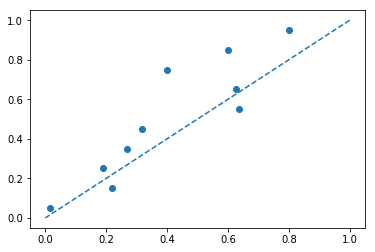

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(example_x, example_y)
plt.plot([1, 0], [1, 0], linestyle = "--")

In [8]:
from sklearn.calibration import calibration_curve

In [9]:
x_axis, y_axis = calibration_curve(example_output1['outcome'].values, example_output1['prediction'], n_bins = 10)

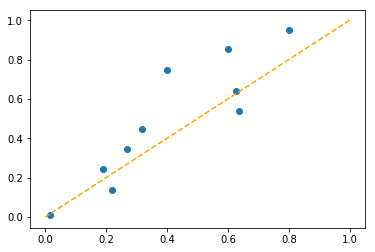

In [10]:
plt.scatter(x_axis, y_axis)
plt.plot([1,0], [1,0], linestyle = "--", color = "orange")

## Method 1: Platt Scaling

Platt Scaling is one method for calibrating machine learning models. Although the original method was applied to a type of model known as a Support Vector Machine, it has become popular for use in general calibration. 

In general, the approach as defined in the original Platt Scaling [paper](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=46EC9FD65BED44B0084980AE055DED68?doi=10.1.1.41.1639&rep=rep1&type=pdf) can be thought of as the following:

If your model generates an output $f$ (can be any real number), use just the model output along with an intercept and the following logistic regression:

$$P(y=1|f) = \frac{1}{1+exp(-(\beta_0 + \beta_1f))}$$

In other words, the scaling is simply applying a logistic regression which maps the output value of a model to a value between 0 and 1. In practice, there are several steps that need to be taken to ensure that this works correctly, and it is important to assess how well the calibration actually works (there are cases where this procedure may either work, but decrease the accuracy of the overall model, or fail to address the calibration issue entirely).

From Platt (1999), we see that the optimal approach can be described as the following:

1. If this logistic regression model is fit using the original training data, it may introduce some bias. Therefore, it makes more sense to fit the calibration logistic regression on the test set.

2. Specifically, the following procedure is recommended:
    * Perform cross-validation with k-folds in the training set to identify the best values of hyperparameters for the original model
    * At each test fold (k total), evaluate the model and *store* the predicted outputs
    * Find the best values of the hyperparameters by averaging the error (or other metric) across all folds
    * For each run of the model with the best hyperparameters, aggregate the predictions and results over the kth fold. This should result in predictions for every data point in the training set (the models will have been trained on different folds).
    * Use these predictions and outcomes to fit the parameters of the logistic regression

3. In addition, Platt also argues that rather than using 1 and 0 for the outputs, that different values should be used (In practice, sometimes this does not make a difference)
 > The probability of the correct label can be derived using Bayes' rule. Let us choose a uniform
uninformative prior over probabilities of correct label. Now, let us observe $N_+$ positive examples.
The MAP estimate for the target probability of positive examples is:

$$ t_+ = \frac{N_+ + 1}{N_+ + 2} $$

>Similarly, if there are $N_-$ negative examples, then the MAP estimate for the target probability
of negative examples is
$$ t_- = \frac{1}{N_- + 2} $$

>These targets are used instead of 1s and 0s

## Method 2: Isotonic Regression

The second method for calibration is known as isotonic regression. Isotonic Regression finds a monotonic step function that minimizes some error. The details for this algorithm are beyond the scope of this class. However, the end result is illustrated below.

![](./assets/isotonic_regression.svg)

The use of isotonic regression to calibrate a model is quite simple. Take the predicted outputs from a model and apply isotonic regression to scale the probabilities to be as close as possible to the empirical values.

Luckily, the `scikit-learn` package provides useful isotonic regression tools.

In [72]:
from sklearn.isotonic import IsotonicRegression

In [73]:
isotonic_calibration = IsotonicRegression()

In [102]:
isotonic_calibration.fit(example_output1['prediction'], example_output1['outcome'])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None,
          y_min=None)

In [103]:
isotonic_calibration.f_

In [104]:
example_output1['prediction']

0        0.988018
1        0.986377
2        0.981420
3        0.980582
4        0.975002
5        0.952916
6        0.929478
7        0.913755
8        0.908941
9        0.900041
10       0.897301
11       0.877191
12       0.871930
13       0.858578
14       0.857898
15       0.844648
16       0.838386
17       0.837858
18       0.822572
19       0.808419
20       0.788154
21       0.771540
22       0.738663
23       0.732124
24       0.705606
25       0.683181
26       0.675663
27       0.664319
28       0.653225
29       0.617853
           ...   
13634    0.000120
13635    0.000119
13636    0.000115
13637    0.000114
13638    0.000112
13639    0.000111
13640    0.000110
13641    0.000110
13642    0.000104
13643    0.000104
13644    0.000102
13645    0.000100
13646    0.000097
13647    0.000097
13648    0.000095
13649    0.000095
13650    0.000095
13651    0.000095
13652    0.000090
13653    0.000087
13654    0.000085
13655    0.000081
13656    0.000081
13657    0.000081
13658    0

In [105]:
new_predictions = isotonic_calibration.f_(example_output1['prediction'].values)

In [106]:
new_predictions

array([1., 1., 1., ..., 0., 0., 0.])

In [116]:
new_predictions_test = isotonic_calibration.transform(example_output1['prediction'].values)

In [107]:
x_axis, y_axis = calibration_curve(example_output1['outcome'].values, new_predictions, n_bins = 10)

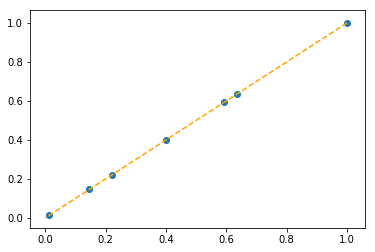

In [108]:
plt.scatter(x_axis, y_axis)
plt.plot([1,0], [1,0], linestyle = "--", color = "orange")

In [109]:
example_output2 = pd.read_csv("./assets/example_output2.csv")

In [112]:
example_output2.head()

,outcome,prediction
0,0,0.983176
1,1,0.972331
2,1,0.932701
3,0,0.908685
4,1,0.907392


In [114]:
held_out_set_predictions = isotonic_calibration.f_(example_output2['prediction'])

In [123]:
x_axis, y_axis = calibration_curve(example_output2['outcome'].values, held_out_set_predictions, n_bins = 10)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


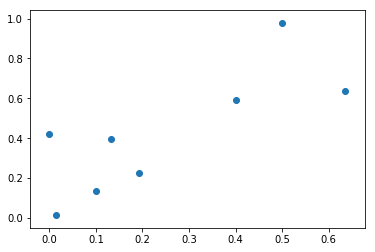

In [124]:
plt.scatter(x_axis, y_axis)

## Brier Score

Although calibration can often be assessed from a purely graphical perspective, there are additional metrics that can be used to assess calibration. The most common of these is known as the Brier Score, which is simly the mean square error of the prediction. 

If the model prediction is given by $f$ and the original label is given by $y$, the Brier Score can be expressed as:

$$ \frac{1}{N}\sum_{i=1}^{N}(y_i - f_i)^2 $$

Although the mean square error is often used for problems where $y_i$ can be any real number, the Brier Score applies to binary classification. The Brier Score can also be extended to multi-class problems, though the binary classification formulation is by far the most popular.